In [1]:
!pip install xgboost lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from scipy import stats
from scipy.stats import shapiro
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [3]:
class DataLoader:
    def __init__(self):
        self.datasets = {}
        self.metadata = {}

    def load_datasets(self):
        files = {
            'combined': 'combined.csv',
            'city_day': 'city_day.csv',
            'city_hour': 'city_hour.csv',
            'station_day': 'station_day.csv',
            'station_hour': 'station_hour.csv',
            'stations': 'stations.csv',
            'cpcb': 'cpcb.csv'
        }

        for name, file in files.items():
            df = pd.read_csv(file)
            self.datasets[name] = df
            self.metadata[name] = {
                'shape': df.shape,
                'memory_usage': df.memory_usage(deep=True).sum(),
                'missing_percentage': (df.isnull().sum() / len(df) * 100).round(2)
            }
            print(f"Loaded {name}: {df.shape[0]:,} rows, {df.shape[1]} columns")

        return self.datasets, self.metadata

    def report(self):
        report = {}
        for name, df in self.datasets.items():
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            report[name] = {
                'completeness': (1 - df.isnull().sum() / len(df)).mean(),
                'uniqueness': df.nunique().sum() / (df.shape[0] * df.shape[1]),
                'numeric_ratio': len(numeric_cols) / df.shape[1] if df.shape[1] > 0 else 0
            }
        return pd.DataFrame(report).T

loader = DataLoader()
datasets, metadata = loader.load_datasets()

quality_report = loader.report()
print("\nData Quality Report:")
print(quality_report.round(3))


Loaded combined: 7,659 rows, 7 columns
Loaded city_day: 29,531 rows, 16 columns
Loaded city_hour: 707,875 rows, 16 columns
Loaded station_day: 108,035 rows, 16 columns
Loaded station_hour: 2,589,083 rows, 16 columns
Loaded stations: 230 rows, 5 columns
Loaded cpcb: 3,078 rows, 11 columns

Data Quality Report:
              completeness  uniqueness  numeric_ratio
combined             0.973       0.045          0.429
city_day             0.813       0.160          0.812
city_hour            0.778       0.023          0.812
station_day          0.755       0.079          0.812
station_hour         0.718       0.009          0.812
stations             0.916       0.530          0.000
cpcb                 0.975       0.062          0.455


In [4]:
class Preprocessor:
    def __init__(self):
        self.outlier_stats = {}

    def detect_outliers(self, df, columns=None):
        if columns is None:
            columns = df.select_dtypes(include=[np.number]).columns

        if len(columns) == 0:
            return pd.DataFrame()

        outlier_methods = {}

        for col in columns:
            if col in df.columns:
                data = df[col].dropna()

                if len(data) == 0:
                    continue

                Q1, Q3 = np.percentile(data, [25, 75])
                IQR = Q3 - Q1
                iqr_outliers = ((data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR)).sum()

                if len(data) > 1:
                    z_scores = np.abs(stats.zscore(data))
                    zscore_outliers = (z_scores > 3).sum()
                else:
                    zscore_outliers = 0

                median = np.median(data)
                mad = np.median(np.abs(data - median))
                if mad != 0:
                    modified_z_scores = 0.6745 * (data - median) / mad
                    modified_outliers = (np.abs(modified_z_scores) > 3.5).sum()
                else:
                    modified_outliers = 0

                outlier_methods[col] = {
                    'iqr_outliers': iqr_outliers,
                    'zscore_outliers': zscore_outliers,
                    'modified_zscore_outliers': modified_outliers,
                    'total_points': len(data)
                }

        return pd.DataFrame(outlier_methods).T if outlier_methods else pd.DataFrame()

    def impute_missing_values(self, df):
        df_processed = df.copy()
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        categorical_cols = df.select_dtypes(exclude=[np.number]).columns

        date_cols = ['Date', 'Datetime']
        for col in date_cols:
            if col in df.columns:
                df_processed[col] = pd.to_datetime(df_processed[col], errors='coerce')

        if len(numeric_cols) > 0:
            missing_percentages = df[numeric_cols].isnull().sum() / len(df)

            low_missing = missing_percentages[missing_percentages < 0.1].index
            if len(low_missing) > 0:
                knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
                df_processed[low_missing] = knn_imputer.fit_transform(df_processed[low_missing])

            med_missing = missing_percentages[(missing_percentages >= 0.1) & (missing_percentages < 0.3)].index
            if len(med_missing) > 0:
                iterative_imputer = IterativeImputer(random_state=42)
                df_processed[med_missing] = iterative_imputer.fit_transform(df_processed[med_missing])

            high_missing = missing_percentages[missing_percentages >= 0.3].index
            for col in high_missing:
                if 'AQI' in col.upper():
                    df_processed[col] = df_processed[col].fillna(df_processed[col].median())
                else:
                    df_processed[col] = df_processed[col].fillna(0)

        for col in categorical_cols:
            if col in df_processed.columns:
                mode_val = df_processed[col].mode()
                if len(mode_val) > 0:
                    df_processed[col] = df_processed[col].fillna(mode_val[0])

        return df_processed

    def treat_outliers(self, df, method='winsorize'):
        df_processed = df.copy()
        numeric_cols = df.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            if col in df.columns:
                data = df_processed[col]

                if method == 'winsorize':
                    lower, upper = np.percentile(data.dropna(), [1, 99])
                    df_processed[col] = np.clip(data, lower, upper)

                elif method == 'log_transform':
                    if data.min() > 0:
                        skewness = stats.skew(data.dropna())
                        if abs(skewness) > 1:
                            df_processed[col] = np.log1p(data)

        return df_processed

preprocessor = Preprocessor()

print("\nPreprocessing Pipeline:")
print("-" * 20)

processed_datasets = {}
for name, df in datasets.items():
    print(f"\nProcessing {name}...")

    outlier_stats = preprocessor.detect_outliers(df)
    print(f"Outlier analysis completed - {len(outlier_stats)} numeric columns")

    df_imputed = preprocessor.impute_missing_values(df)
    print(f"Missing values: {df.isnull().sum().sum()} -> {df_imputed.isnull().sum().sum()}")

    df_final = preprocessor.treat_outliers(df_imputed, method='winsorize')
    processed_datasets[name] = df_final

    print(f"{name} processed successfully")



Preprocessing Pipeline:
--------------------

Processing combined...
Outlier analysis completed - 3 numeric columns
Missing values: 1460 -> 0
combined processed successfully

Processing city_day...
Outlier analysis completed - 13 numeric columns
Missing values: 88488 -> 0
city_day processed successfully

Processing city_hour...
Outlier analysis completed - 13 numeric columns
Missing values: 2515685 -> 0
city_hour processed successfully

Processing station_day...
Outlier analysis completed - 13 numeric columns
Missing values: 422673 -> 0
station_day processed successfully

Processing station_hour...
Outlier analysis completed - 13 numeric columns
Missing values: 11664492 -> 0
station_hour processed successfully

Processing stations...
Outlier analysis completed - 0 numeric columns
Missing values: 97 -> 0
stations processed successfully

Processing cpcb...
Outlier analysis completed - 5 numeric columns
Missing values: 858 -> 0
cpcb processed successfully


In [5]:
class FeatureEngineer:
    def __init__(self):
        self.feature_importance = {}

    def temporal_features(self, df, date_col):
        if date_col in df.columns:
            df = df.copy()
            df[date_col] = pd.to_datetime(df[date_col])

            df['year'] = df[date_col].dt.year
            df['month'] = df[date_col].dt.month
            df['day'] = df[date_col].dt.day
            df['day_of_week'] = df[date_col].dt.dayofweek
            df['day_of_year'] = df[date_col].dt.dayofyear
            df['week_of_year'] = df[date_col].dt.isocalendar().week
            df['quarter'] = df[date_col].dt.quarter

            df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
            df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
            df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
            df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

            df['season'] = df['month'].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1,
                                         6:2, 7:2, 8:2, 9:3, 10:3, 11:3})

            df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

        return df

    def pollution_features(self, df):
        df = df.copy()
        pollutant_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

        available_pollutants = [col for col in pollutant_cols if col in df.columns]

        if len(available_pollutants) >= 2:
            if 'PM2.5' in df.columns and 'PM10' in df.columns:
                df['PM_ratio'] = df['PM2.5'] / (df['PM10'] + 1e-8)

            if 'NO2' in df.columns and 'NO' in df.columns:
                df['NOx_efficiency'] = df['NO2'] / (df['NO'] + df['NO2'] + 1e-8)

            if len(available_pollutants) >= 3:
                pca = PCA(n_components=1)
                pollution_load = pca.fit_transform(df[available_pollutants].fillna(0))
                df['pollution_load_pc1'] = pollution_load.flatten()

        if 'AQI' in df.columns:
            df['AQI_category'] = pd.cut(df['AQI'],
                                      bins=[0, 50, 100, 150, 200, 300, 500],
                                      labels=['Good', 'Satisfactory', 'Moderate',
                                            'Poor', 'Very Poor', 'Severe'])
            df['AQI_log'] = np.log1p(df['AQI'])

        return df

    def spatial_features(self, df):
        df = df.copy()

        city_weights = {
            'Delhi': 1.0, 'Mumbai': 0.9, 'Kolkata': 0.8, 'Chennai': 0.7,
            'Bangalore': 0.6, 'Hyderabad': 0.6, 'Ahmedabad': 0.5, 'Pune': 0.5
        }

        if 'City' in df.columns:
            df['city_weight'] = df['City'].map(city_weights).fillna(0.3)
            city_dummies = pd.get_dummies(df['City'], prefix='city')
            df = pd.concat([df, city_dummies], axis=1)

        return df

feature_engineer = FeatureEngineer()

if 'city_day' in processed_datasets:
    master_df = processed_datasets['city_day'].copy()

    master_df = feature_engineer.temporal_features(master_df, 'Date')
    print(f"Temporal features added: {master_df.shape[1] - processed_datasets['city_day'].shape[1]} new features")

    master_df = feature_engineer.pollution_features(master_df)
    print("Pollution features added")

    master_df = feature_engineer.spatial_features(master_df)
    print("Spatial features added")

    if 'station_day' in processed_datasets:
        station_df = processed_datasets['station_day']
        required_cols = ['City', 'Date']

        if all(col in station_df.columns for col in required_cols):
            numeric_cols = station_df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                station_agg = station_df.groupby(['City', 'Date']).agg({
                    col: ['mean', 'std', 'min', 'max'] for col in numeric_cols
                }).reset_index()

                station_agg.columns = ['_'.join(col).strip('_') for col in station_agg.columns]
                station_agg = station_agg.rename(columns={'City_': 'City', 'Date_': 'Date'})

                master_df = master_df.merge(station_agg, on=['City', 'Date'], how='left', suffixes=('', '_station'))
                print("Station aggregates merged")
            else:
                print("Station data has no numeric columns to aggregate")

Temporal features added: 13 new features
Pollution features added
Spatial features added


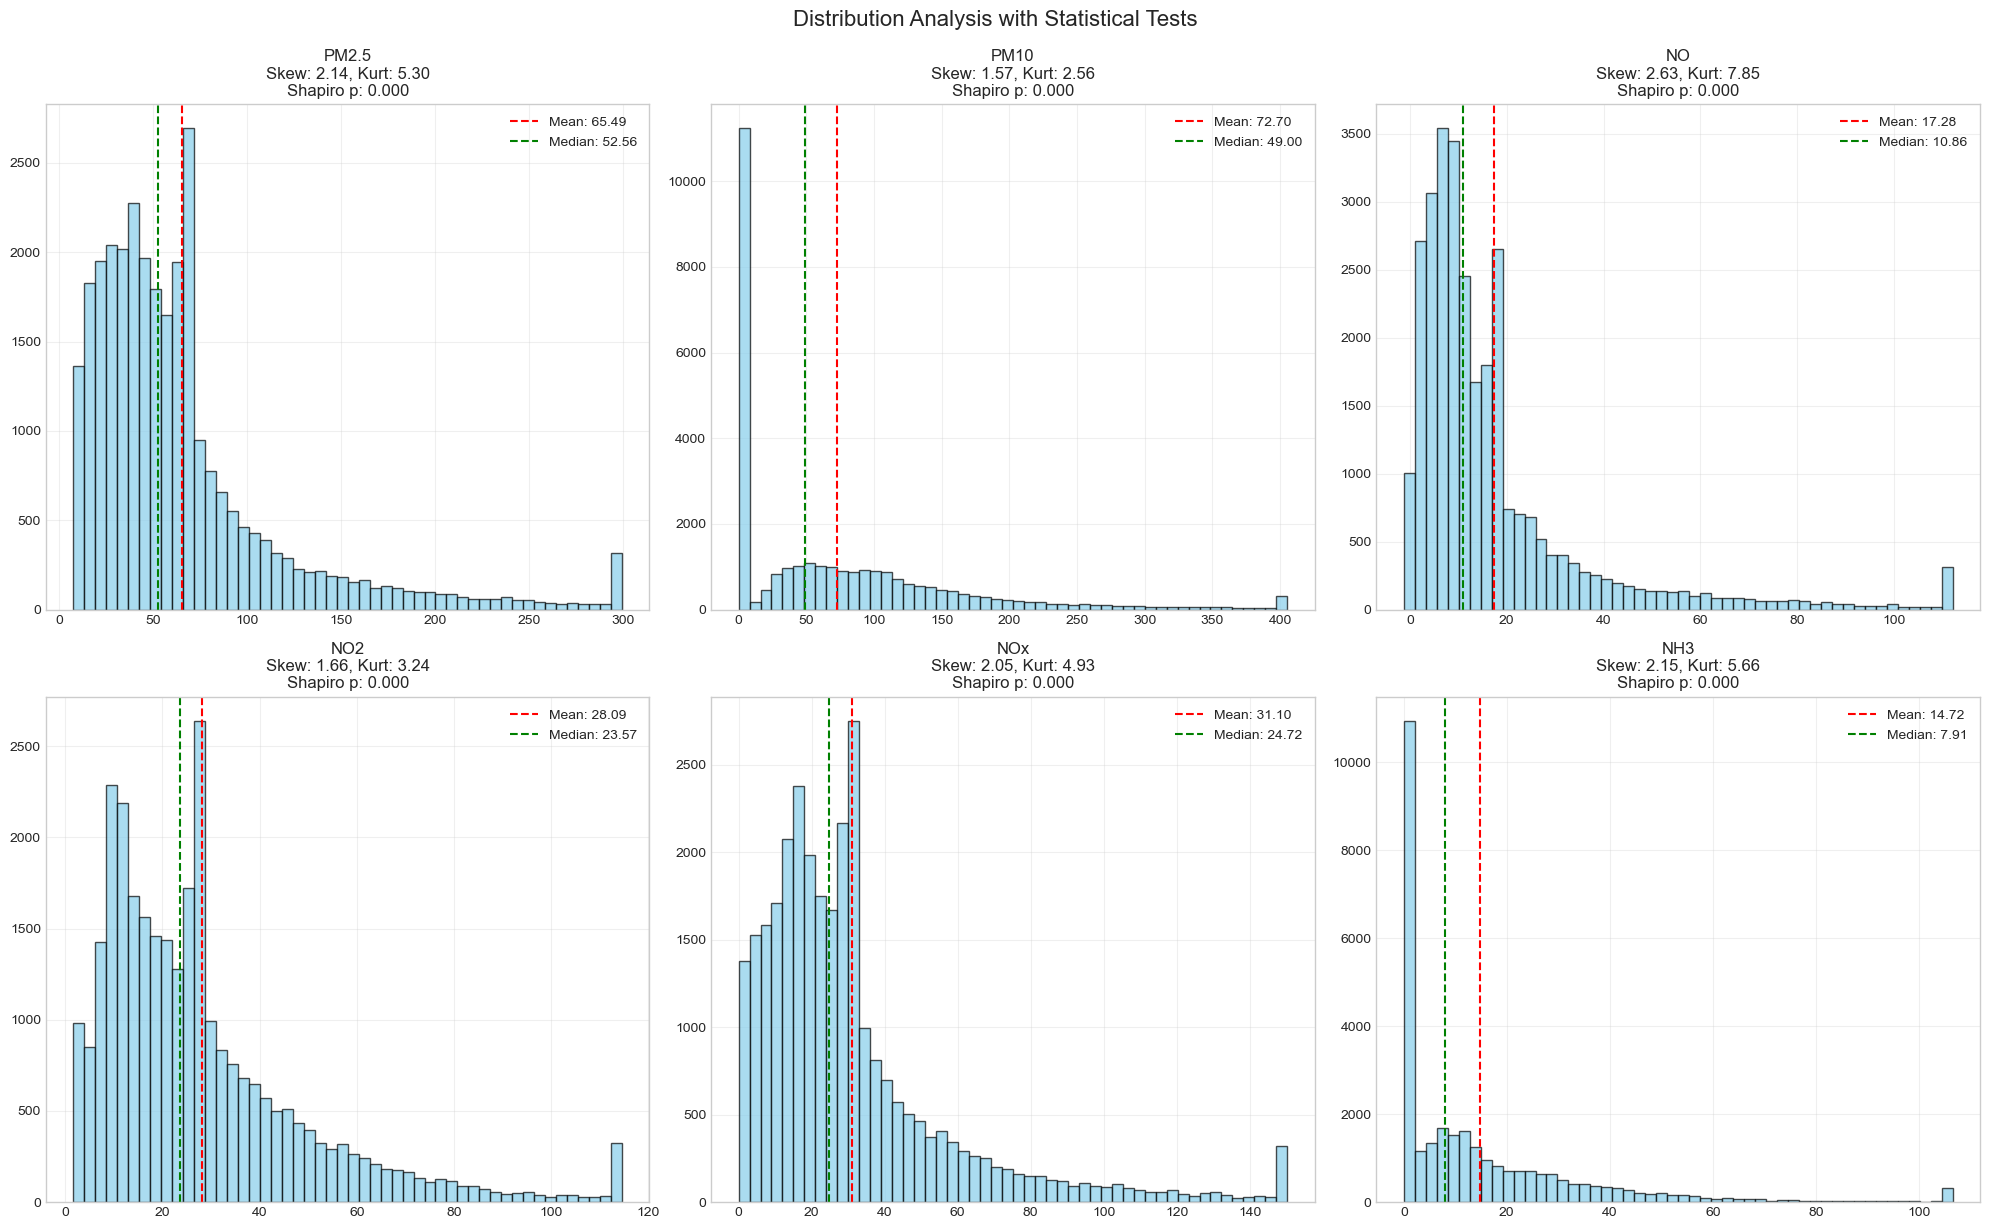

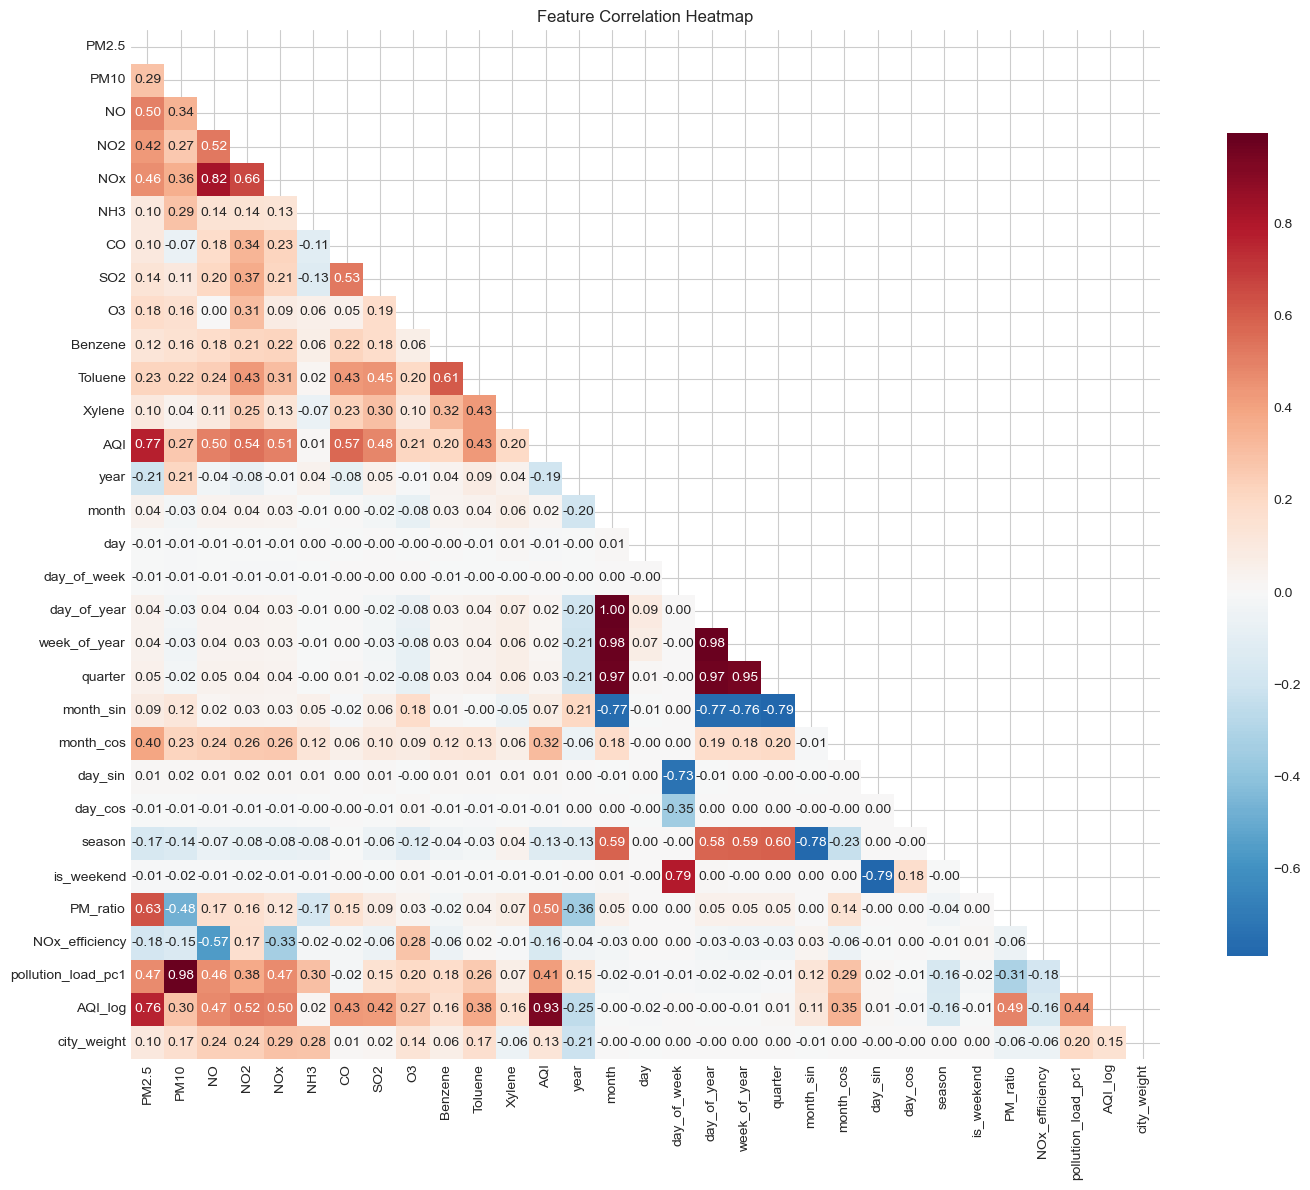

High correlation pairs (|r| > 0.8):
PM10 - pollution_load_pc1: 0.980
NO - NOx: 0.822
AQI - AQI_log: 0.934
month - day_of_year: 0.996
month - week_of_year: 0.977
month - quarter: 0.971
day_of_year - week_of_year: 0.979
day_of_year - quarter: 0.968
week_of_year - quarter: 0.951


In [6]:
class EDAAnalyzer:
    def __init__(self, df):
        self.df = df
        self.numeric_cols = df.select_dtypes(include=[np.number]).columns

    def distribution_analysis(self):
        n_cols = min(6, len(self.numeric_cols))
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        axes = axes.ravel()

        for i, col in enumerate(self.numeric_cols[:n_cols]):
            data = self.df[col].dropna()

            axes[i].hist(data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
            axes[i].axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.2f}')
            axes[i].axvline(data.median(), color='green', linestyle='--', label=f'Median: {data.median():.2f}')

            _, shapiro_p = shapiro(data.sample(min(5000, len(data))) if len(data) > 5000 else data)
            skewness = stats.skew(data)
            kurtosis = stats.kurtosis(data)

            axes[i].set_title(f'{col}\nSkew: {skewness:.2f}, Kurt: {kurtosis:.2f}\nShapiro p: {shapiro_p:.3f}')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.suptitle('Distribution Analysis with Statistical Tests', y=1.02, fontsize=16)
        plt.show()

    def correlation_heatmap(self):
        corr_matrix = self.df[self.numeric_cols].corr()

        plt.figure(figsize=(15, 12))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                    square=True, fmt='.2f', cbar_kws={"shrink": .8})
        plt.title('Feature Correlation Heatmap')
        plt.tight_layout()
        plt.show()

        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > 0.8:
                    high_corr_pairs.append((corr_matrix.columns[i],
                                          corr_matrix.columns[j],
                                          corr_matrix.iloc[i, j]))

        if high_corr_pairs:
            print("High correlation pairs (|r| > 0.8):")
            for pair in high_corr_pairs[:10]:
                print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

eda = EDAAnalyzer(master_df)
eda.distribution_analysis()
eda.correlation_heatmap()



Dimensionality Reduction:
-----------------------


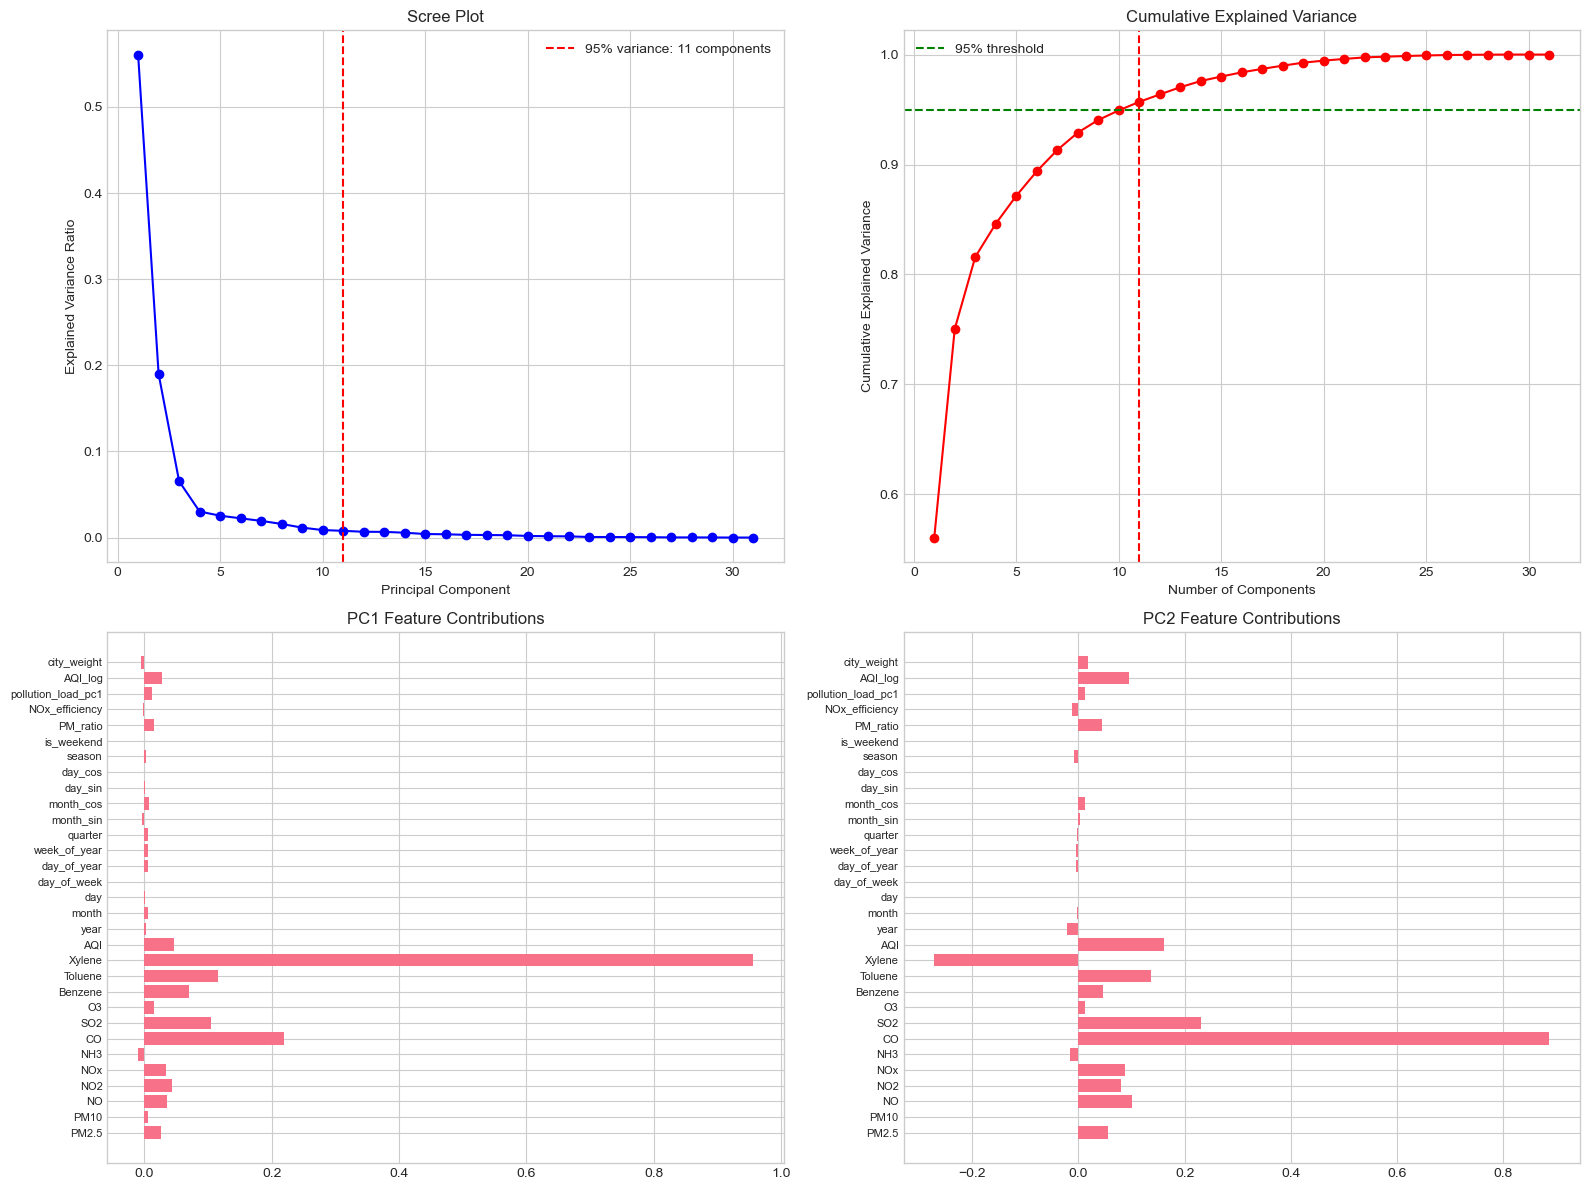

Optimal number of components for 95% variance: 11

Pipeline execution completed successfully!
Ready for model selection and training phase.


In [7]:
class DimensionalityReducer:
    def __init__(self, df):
        self.df = df
        self.numeric_df = df.select_dtypes(include=[np.number]).dropna()
        self.scaler = RobustScaler()

    def pca_analysis(self):
        X_scaled = self.scaler.fit_transform(self.numeric_df)

        pca_full = PCA()
        X_pca_full = pca_full.fit_transform(X_scaled)

        cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
        n_components_95 = np.argmax(cumsum_var >= 0.95) + 1

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        axes[0,0].plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
                      pca_full.explained_variance_ratio_, 'bo-')
        axes[0,0].axvline(n_components_95, color='red', linestyle='--',
                         label=f'95% variance: {n_components_95} components')
        axes[0,0].set_title('Scree Plot')
        axes[0,0].set_xlabel('Principal Component')
        axes[0,0].set_ylabel('Explained Variance Ratio')
        axes[0,0].legend()
        axes[0,0].grid(True)

        axes[0,1].plot(range(1, len(cumsum_var) + 1), cumsum_var, 'ro-')
        axes[0,1].axhline(0.95, color='green', linestyle='--', label='95% threshold')
        axes[0,1].axvline(n_components_95, color='red', linestyle='--')
        axes[0,1].set_title('Cumulative Explained Variance')
        axes[0,1].set_xlabel('Number of Components')
        axes[0,1].set_ylabel('Cumulative Explained Variance')
        axes[0,1].legend()
        axes[0,1].grid(True)

        feature_names = self.numeric_df.columns
        pc1_contributions = pca_full.components_[0]
        pc2_contributions = pca_full.components_[1]

        axes[1,0].barh(range(len(feature_names)), pc1_contributions)
        axes[1,0].set_yticks(range(len(feature_names)))
        axes[1,0].set_yticklabels(feature_names, fontsize=8)
        axes[1,0].set_title('PC1 Feature Contributions')
        axes[1,0].grid(True)

        axes[1,1].barh(range(len(feature_names)), pc2_contributions)
        axes[1,1].set_yticks(range(len(feature_names)))
        axes[1,1].set_yticklabels(feature_names, fontsize=8)
        axes[1,1].set_title('PC2 Feature Contributions')
        axes[1,1].grid(True)

        plt.tight_layout()
        plt.show()

        return n_components_95

print("\nDimensionality Reduction:")
print("-" * 23)

dim_reducer = DimensionalityReducer(master_df)
optimal_components = dim_reducer.pca_analysis()

print(f"Optimal number of components for 95% variance: {optimal_components}")

print("\nPipeline execution completed successfully!")
print("Ready for model selection and training phase.")

In [8]:
!pip install catboost joblib

In [9]:
import time
import catboost as cb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def clean_data(master_df, target_column='AQI'):
    print(f"Initial shape: {master_df.shape}")
    df = master_df.copy()
    leakage_columns = [
        'AQI_category', 'AQI_log',  
        'AQI_Bucket', 'AQI_Range', 'AQI_Level'  
    ]
    
    leakage_found = []
    for col in leakage_columns:
        if col in df.columns:
            df = df.drop(columns=[col])
            leakage_found.append(col)
    
    if leakage_found:
        print(f"Removed potential leakage columns: {leakage_found}")
    
    df_clean = df.dropna(subset=[target_column])
    print(f"After removing missing targets: {df_clean.shape}")
  
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    
    remove_cols = ['Date', 'Datetime', 'City']
    for col in remove_cols:
        if col in X.columns:
            X = X.drop(columns=[col])
    
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X_numeric = X[numeric_cols]
    
    final_features = []
    for col in X_numeric.columns:
        missing_pct = X_numeric[col].isnull().sum() / len(X_numeric)
        if missing_pct > 0.6:
            continue
        if X_numeric[col].var() < 1e-10:
            continue
            
        if col != target_column:
            final_features.append(col)
    
    X_final = X_numeric[final_features]
    
    for col in X_final.columns:
        if X_final[col].isnull().sum() > 0:
            X_final[col] = X_final[col].fillna(X_final[col].median())
  
    mask = ~(X_final.isnull().any(axis=1) | y.isnull())
    X_final = X_final[mask]
    y = y[mask]
    
    print(f"Final dataset: {X_final.shape[0]} samples, {X_final.shape[1]} features")
    print(f"Target statistics: min={y.min():.2f}, max={y.max():.2f}, mean={y.mean():.2f}")
    
    return X_final, y


In [10]:
X, y = clean_data(master_df)

def create_robust_split(X, y, test_size=0.25, random_state=42):
    """Create robust train-test split"""
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )
    
    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_robust_split(X, y)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=X_test.columns, 
    index=X_test.index
)


Initial shape: (29531, 61)
Removed potential leakage columns: ['AQI_category', 'AQI_log', 'AQI_Bucket']
After removing missing targets: (29531, 58)
Final dataset: 29531 samples, 29 features
Target statistics: min=34.00, max=626.40, mean=162.28
Train set: 22148 samples
Test set: 7383 samples


In [11]:
def init_models():
    models = {
        'SVR': SVR(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            epsilon=0.1
        ),
        
        'Ridge_Regression': Ridge(
            alpha=1.0,
            fit_intercept=True
        ),
        
        'RandomForest': RandomForestRegressor(
            n_estimators=150,
            max_depth=12,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ),
        
        'XGBoost': xgb.XGBRegressor(
            n_estimators=150,
            learning_rate=0.08,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        ),
        
        'LightGBM': lgb.LGBMRegressor(
            n_estimators=150,
            learning_rate=0.08,
            max_depth=8,
            num_leaves=50,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            verbosity=-1
        ),

        'GradientBoosting': GradientBoostingRegressor(
            n_estimators=150,
            learning_rate=0.08,
            max_depth=8,
            subsample=0.8,
            random_state=42
        ),
        
        'ExtraTrees': ExtraTreesRegressor(
            n_estimators=150,
            max_depth=12,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
    }
    
    return models

models = init_models()
for name in models.keys():
    print(f" * {name}")

 * SVR
 * Ridge_Regression
 * RandomForest
 * XGBoost
 * LightGBM
 * GradientBoosting
 * ExtraTrees


In [12]:
def crossValid(models, X_train, X_train_scaled, y_train):
    cv_results = {}
    trained_models = {}
    
    scale_required = ['SVR', 'Ridge_Regression']
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        X_cv = X_train_scaled if name in scale_required else X_train
        
        cv_scores = cross_val_score(
            model, X_cv, y_train,
            cv=5,
            scoring='r2',
            n_jobs=-1
        )
        
        cv_results[name] = {
            'mean_cv_r2': cv_scores.mean(),
            'std_cv_r2': cv_scores.std(),
            'cv_scores': cv_scores
        }
        model.fit(X_cv, y_train)
        trained_models[name] = model
        
        print(f"  CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    return trained_models, cv_results

trained_models, cv_results = crossValid(
    models, X_train, X_train_scaled, y_train
)

def evaluateModels(trained_models, X_test, X_test_scaled, y_test):    
    print("\nEvaluating")
    print("=" * 45)
    
    scale_required = ['SVR', 'Ridge_Regression']
    results = {}
    
    for name, model in trained_models.items():
        print(f"Evaluating {name}...")
        
        try:
            X_test_model = X_test_scaled if name in scale_required else X_test
            y_pred = model.predict(X_test_model)
            if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
                print(f"Warning: {name} produced invalid predictions, skipping...")
                continue
            metrics = {}
            metrics['R²'] = r2_score(y_test, y_pred)
            metrics['RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
            metrics['MAE'] = mean_absolute_error(y_test, y_pred)
            try:
                metrics['MAPE'] = mean_absolute_percentage_error(y_test, y_pred) * 100
            except:
                mask = y_test != 0
                if np.sum(mask) > 0:
                    metrics['MAPE'] = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
                else:
                    metrics['MAPE'] = np.nan
            
            n_samples = len(y_test)
            n_features = X_test.shape[1]
            if metrics['R²'] < 1:  
                adj_r2 = 1 - (1 - metrics['R²']) * (n_samples - 1) / (n_samples - n_features - 1)
                metrics['Adj_R²'] = adj_r2
            else:
                metrics['Adj_R²'] = metrics['R²']
            
            if name in cv_results:
                metrics['CV_R²_Mean'] = cv_results[name]['mean_cv_r2']
                metrics['CV_R²_Std'] = cv_results[name]['std_cv_r2']
            else:
                metrics['CV_R²_Mean'] = np.nan
                metrics['CV_R²_Std'] = np.nan
            
            results[name] = metrics
            
            print(f"  R²: {metrics['R²']:.4f} | RMSE: {metrics['RMSE']:.2f} | MAE: {metrics['MAE']:.2f}")
            
        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            continue
    
    return results
    
evaluation_results = evaluateModels(
    trained_models, X_test, X_test_scaled, y_test
)



Training SVR...
  CV R²: 0.7444 ± 0.0110

Training Ridge_Regression...
  CV R²: 0.8750 ± 0.0014

Training RandomForest...
  CV R²: 0.9139 ± 0.0044

Training XGBoost...
  CV R²: 0.9237 ± 0.0035

Training LightGBM...
  CV R²: 0.9228 ± 0.0030

Training GradientBoosting...
  CV R²: 0.9206 ± 0.0037

Training ExtraTrees...
  CV R²: 0.9172 ± 0.0033

Evaluating
Evaluating SVR...
  R²: 0.7756 | RMSE: 53.22 | MAE: 29.60
Evaluating Ridge_Regression...
  R²: 0.8749 | RMSE: 39.74 | MAE: 24.71
Evaluating RandomForest...
  R²: 0.9203 | RMSE: 31.72 | MAE: 18.38
Evaluating XGBoost...
  R²: 0.9285 | RMSE: 30.04 | MAE: 17.17
Evaluating LightGBM...
  R²: 0.9267 | RMSE: 30.42 | MAE: 17.58
Evaluating GradientBoosting...
  R²: 0.9270 | RMSE: 30.35 | MAE: 17.39
Evaluating ExtraTrees...
  R²: 0.9223 | RMSE: 31.31 | MAE: 18.73


In [13]:
def analyze_results(evaluation_results):
    results_df = pd.DataFrame(evaluation_results).T
    results_df_sorted = results_df.sort_values('R²', ascending=False)
    
    display_cols = ['R²', 'Adj_R²', 'RMSE', 'MAE', 'MAPE', 'CV_R²_Mean', 'CV_R²_Std']
    print(results_df_sorted[display_cols].round(4))
    
    best_model = results_df_sorted.index[0]
    best_metrics = results_df_sorted.iloc[0]
    
    print(f"\nBEST PERFORMING MODEL: {best_model}")
    print("=" * 50)
    print(f"Test R²: {best_metrics['R²']:.4f}")
    print(f"Cross-Val R²: {best_metrics['CV_R²_Mean']:.4f} ± {best_metrics['CV_R²_Std']:.4f}")
    print(f"RMSE: {best_metrics['RMSE']:.2f}")
    print(f"MAE: {best_metrics['MAE']:.2f}")
    print(f"MAPE: {best_metrics['MAPE']:.2f}%")
    
    return results_df_sorted, best_model

final_results, best_model_name = analyze_results(evaluation_results)


                      R²  Adj_R²     RMSE      MAE     MAPE  CV_R²_Mean  \
XGBoost           0.9285  0.9282  30.0434  17.1671  11.8358      0.9237   
GradientBoosting  0.9270  0.9267  30.3510  17.3886  11.9181      0.9206   
LightGBM          0.9267  0.9264  30.4203  17.5805  12.2687      0.9228   
ExtraTrees        0.9223  0.9220  31.3056  18.7313  14.0395      0.9172   
RandomForest      0.9203  0.9199  31.7229  18.3770  13.0772      0.9139   
Ridge_Regression  0.8749  0.8744  39.7408  24.7128  17.4075      0.8750   
SVR               0.7756  0.7747  53.2210  29.5996  19.5390      0.7444   

                  CV_R²_Std  
XGBoost              0.0035  
GradientBoosting     0.0037  
LightGBM             0.0030  
ExtraTrees           0.0033  
RandomForest         0.0044  
Ridge_Regression     0.0014  
SVR                  0.0110  

BEST PERFORMING MODEL: XGBoost
Test R²: 0.9285
Cross-Val R²: 0.9237 ± 0.0035
RMSE: 30.04
MAE: 17.17
MAPE: 11.84%


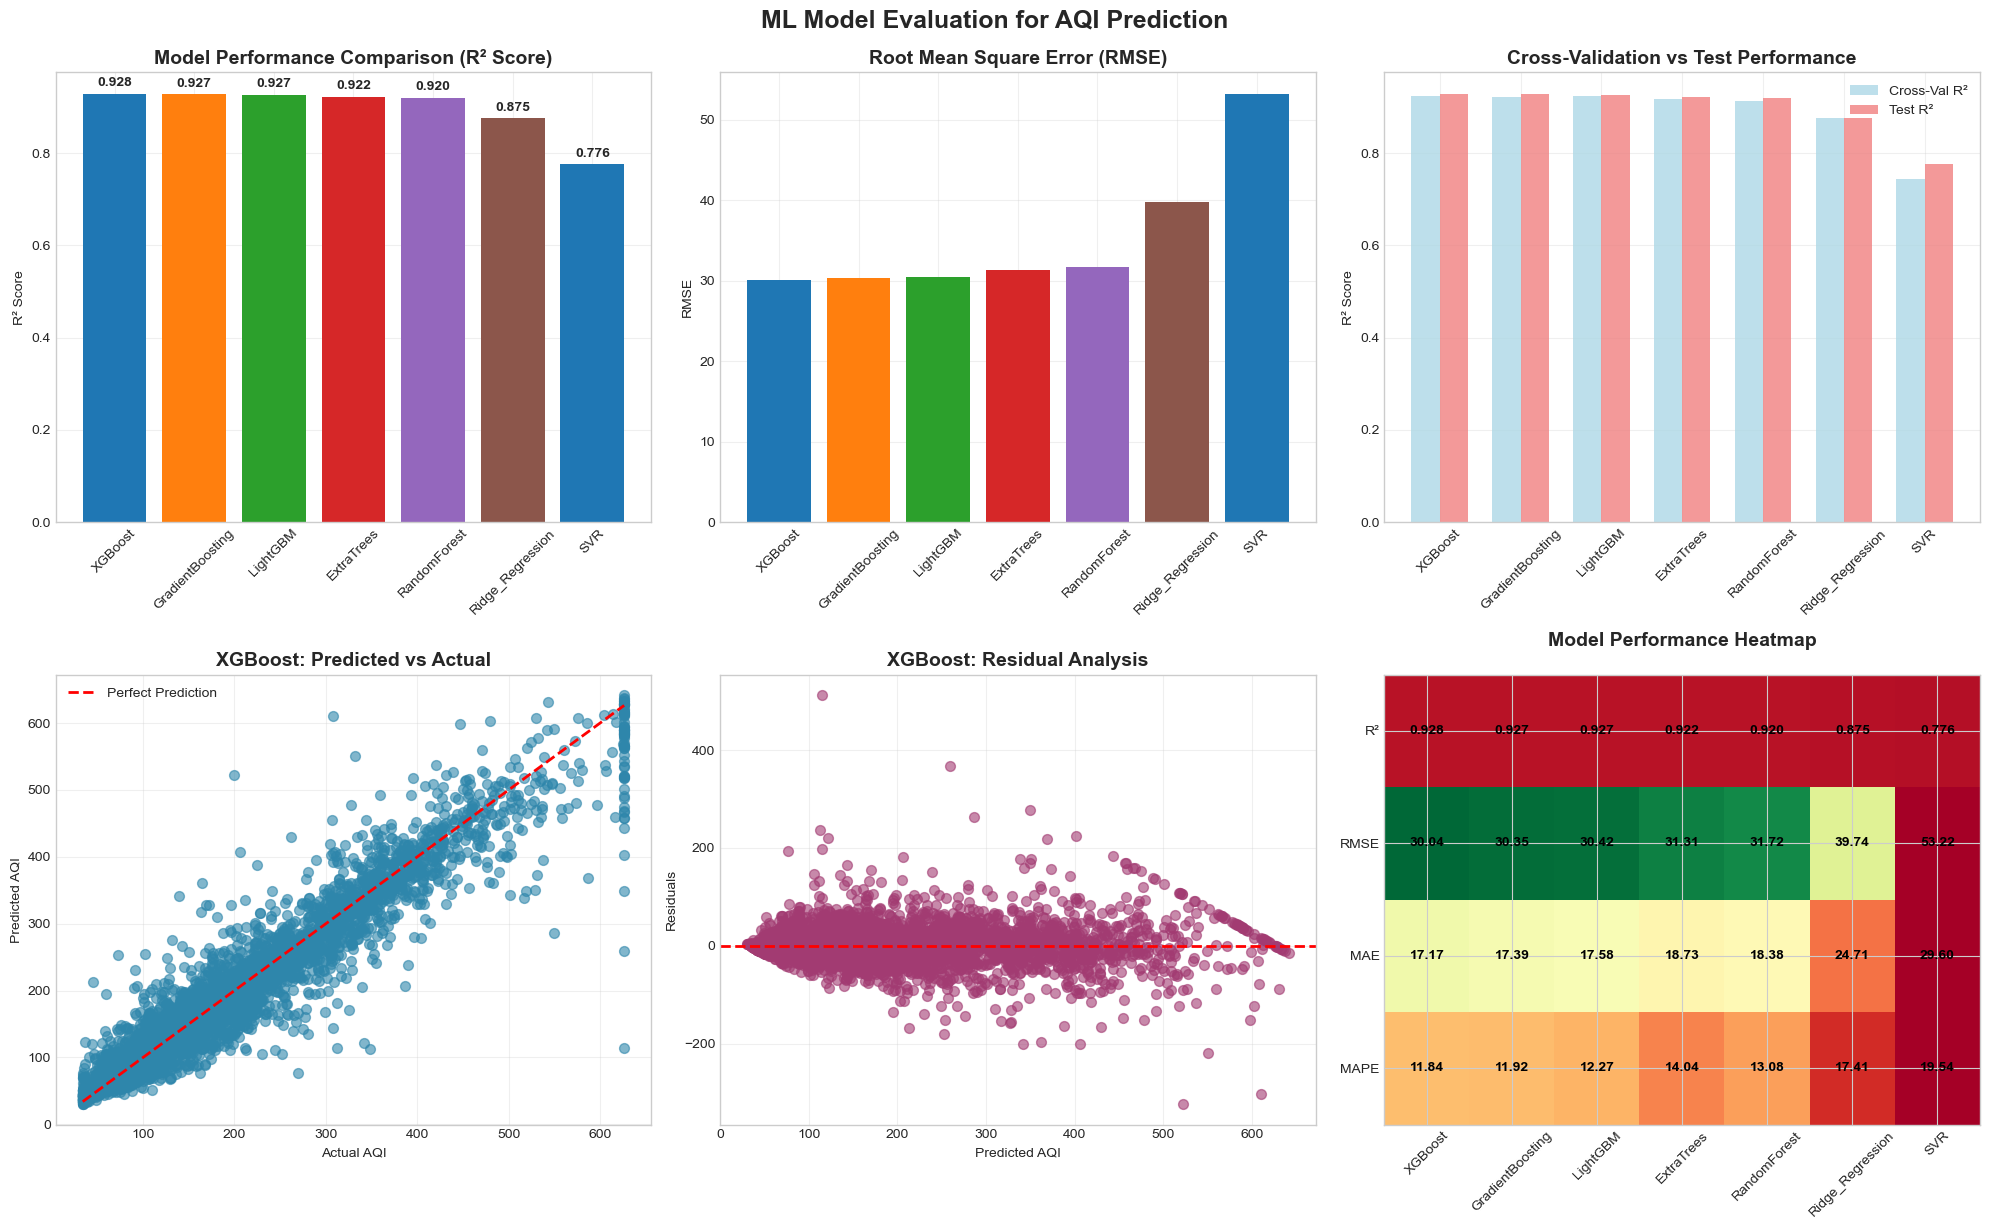

In [14]:
def visualizations(final_results, trained_models, X_test, X_test_scaled, y_test):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    models = final_results.index
    r2_scores = final_results['R²']
    
    bars1 = axes[0,0].bar(models, r2_scores, color=colors)
    axes[0,0].set_title('Model Performance Comparison (R² Score)', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
   
    for bar, score in zip(bars1, r2_scores):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    rmse_scores = final_results['RMSE']
    bars2 = axes[0,1].bar(models, rmse_scores, color=colors)
    axes[0,1].set_title('Root Mean Square Error (RMSE)', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('RMSE')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    cv_r2 = final_results['CV_R²_Mean']
    test_r2 = final_results['R²']
    
    x = np.arange(len(models))
    width = 0.35
    
    bars3a = axes[0,2].bar(x - width/2, cv_r2, width, label='Cross-Val R²', alpha=0.8, color='lightblue')
    bars3b = axes[0,2].bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8, color='lightcoral')
    
    axes[0,2].set_title('Cross-Validation vs Test Performance', fontsize=14, fontweight='bold')
    axes[0,2].set_ylabel('R² Score')
    axes[0,2].set_xticks(x)
    axes[0,2].set_xticklabels(models, rotation=45)
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    scale_required = ['SVR', 'Ridge_Regression']
    X_test_best = X_test_scaled if best_model_name in scale_required else X_test
    best_model = trained_models[best_model_name]
    y_pred_best = best_model.predict(X_test_best)
    
    axes[1,0].scatter(y_test, y_pred_best, alpha=0.6, s=50, color='#2E86AB')
    axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'r--', lw=2, label='Perfect Prediction')
    axes[1,0].set_xlabel('Actual AQI')
    axes[1,0].set_ylabel('Predicted AQI')
    axes[1,0].set_title(f'{best_model_name}: Predicted vs Actual', fontsize=14, fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    residuals = y_test - y_pred_best
    axes[1,1].scatter(y_pred_best, residuals, alpha=0.6, s=50, color='#A23B72')
    axes[1,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1,1].set_xlabel('Predicted AQI')
    axes[1,1].set_ylabel('Residuals')
    axes[1,1].set_title(f'{best_model_name}: Residual Analysis', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    
    metrics_for_heatmap = ['R²', 'RMSE', 'MAE', 'MAPE']
    heatmap_data = final_results[metrics_for_heatmap].T
    
    heatmap_normalized = heatmap_data.copy()
    for col in heatmap_normalized.columns:
        for idx in heatmap_normalized.index:
            if idx == 'R²':  # Higher is better
                heatmap_normalized.loc[idx, col] = heatmap_normalized.loc[idx, col]
            else:  # Lower is better - invert
                max_val = heatmap_data.loc[idx].max()
                heatmap_normalized.loc[idx, col] = max_val - heatmap_normalized.loc[idx, col]
    
    im = axes[1,2].imshow(heatmap_normalized.values, cmap='RdYlGn', aspect='auto')
    axes[1,2].set_xticks(range(len(models)))
    axes[1,2].set_xticklabels(models, rotation=45)
    axes[1,2].set_yticks(range(len(metrics_for_heatmap)))
    axes[1,2].set_yticklabels(metrics_for_heatmap)
    axes[1,2].set_title('Model Performance Heatmap\n', fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i in range(len(metrics_for_heatmap)):
        for j in range(len(models)):
            text = f'{final_results.iloc[j, i]:.3f}' if metrics_for_heatmap[i] == 'R²' else f'{final_results.iloc[j, i]:.2f}'
            axes[1,2].text(j, i, text, ha='center', va='center', color='black', fontweight='bold')
    
    plt.tight_layout()
    plt.suptitle('ML Model Evaluation for AQI Prediction', 
                fontsize=18, fontweight='bold', y=1.02)
    plt.show()
    
    return y_pred_best

predictions = visualizations(
    final_results, trained_models, X_test, X_test_scaled, y_test
)



In [15]:
def summary(final_results, X, y):
    print(f"Dataset Characteristics:")
    print(f"├─ Total samples: {len(X):,}")
    print(f"├─ Features: {X.shape[1]}")
    print(f"├─ Train/Test split: 75%/25%")
    print(f"├─ AQI range: {y.min():.1f} - {y.max():.1f}")
    print(f"└─ AQI mean ± std: {y.mean():.2f} ± {y.std():.2f}")
    
    print(f"\nModel Performance Rankings:")
    for i, (model, row) in enumerate(final_results.head(3).iterrows(), 1):
        print(f"{i}. {model:15} | R²: {row['R²']:.4f} | RMSE: {row['RMSE']:.2f} | CV-R²: {row['CV_R²_Mean']:.4f}")
    
    best_model_row = final_results.iloc[0]
    cv_test_diff = abs(best_model_row['R²'] - best_model_row['CV_R²_Mean'])
    
    print(f"\nModel Validation Analysis:")
    print(f"├─ Best model: {final_results.index[0]}")
    print(f"├─ Test R²: {best_model_row['R²']:.4f}")
    print(f"├─ CV R²: {best_model_row['CV_R²_Mean']:.4f} ± {best_model_row['CV_R²_Std']:.4f}")
    print(f"├─ CV-Test difference: {cv_test_diff:.4f}")
    
    if cv_test_diff < 0.05:
        print(f"Model shows good generalization (difference < 0.05)")
    else:
        print(f"Model may be overfitting (difference > 0.05)")

    r2_values = final_results['R²'].values
    print(f"\nPerformance Distribution:")
    print(f"├─ Best R²: {r2_values.max():.4f}")
    print(f"├─ Worst R²: {r2_values.min():.4f}")
    print(f"├─ Average R²: {r2_values.mean():.4f}")
    print(f"└─ Standard deviation: {r2_values.std():.4f}")

summary(final_results, X, y)

Dataset Characteristics:
├─ Total samples: 29,531
├─ Features: 29
├─ Train/Test split: 75%/25%
├─ AQI range: 34.0 - 626.4
└─ AQI mean ± std: 162.28 ± 113.34

Model Performance Rankings:
1. XGBoost         | R²: 0.9285 | RMSE: 30.04 | CV-R²: 0.9237
2. GradientBoosting | R²: 0.9270 | RMSE: 30.35 | CV-R²: 0.9206
3. LightGBM        | R²: 0.9267 | RMSE: 30.42 | CV-R²: 0.9228

Model Validation Analysis:
├─ Best model: XGBoost
├─ Test R²: 0.9285
├─ CV R²: 0.9237 ± 0.0035
├─ CV-Test difference: 0.0048
Model shows good generalization (difference < 0.05)

Performance Distribution:
├─ Best R²: 0.9285
├─ Worst R²: 0.7756
├─ Average R²: 0.8965
└─ Standard deviation: 0.0524
